In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-object-detection


In [47]:
!pip install -q ultralytics opencv-python pandas matplotlib


In [48]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm


In [49]:
labels = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
labels.head()


image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [50]:
IMG_SRC = "/kaggle/input/car-object-detection/data/training_images"


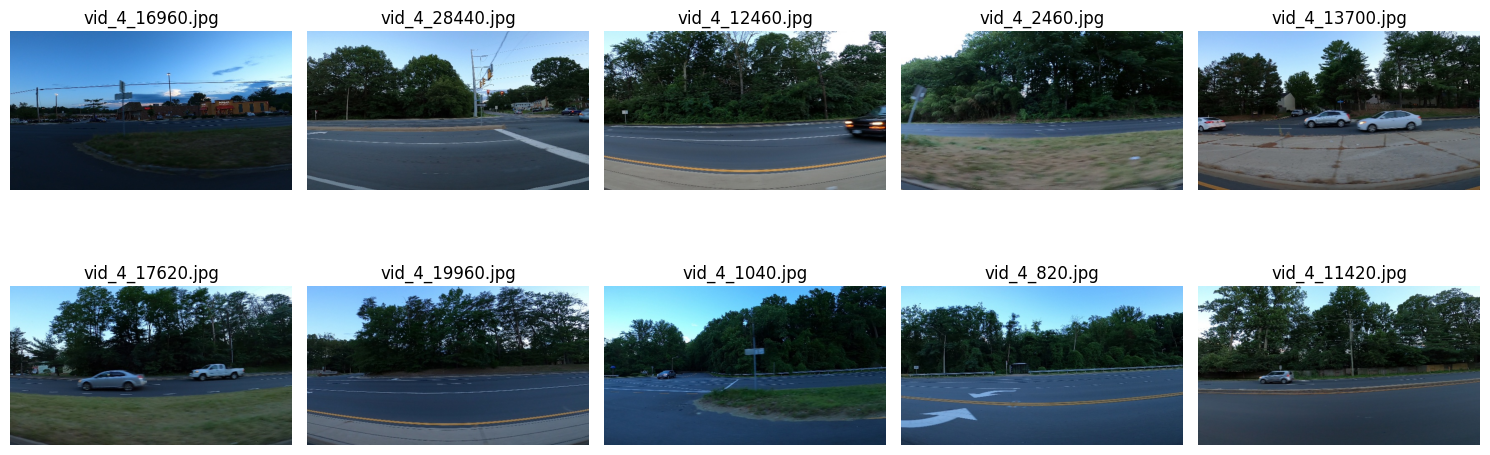

In [51]:
import os
import cv2
import matplotlib.pyplot as plt

IMG_SRC = "/kaggle/input/car-object-detection/data/training_images"

sample_imgs = os.listdir(IMG_SRC)[:10]

plt.figure(figsize=(15,6))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(IMG_SRC, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)

plt.tight_layout()
plt.show()


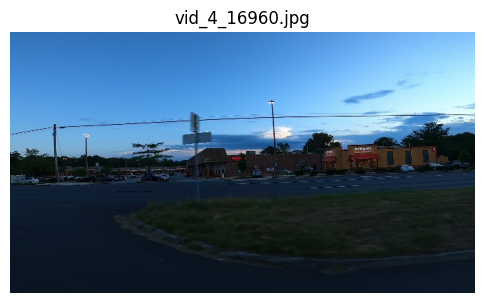

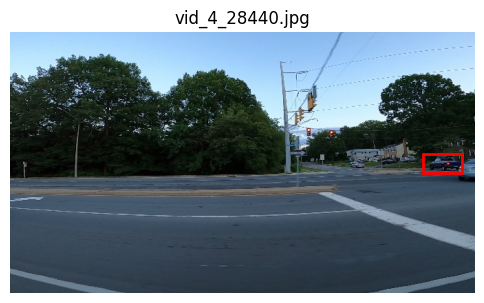

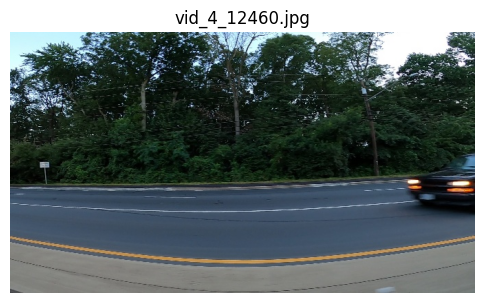

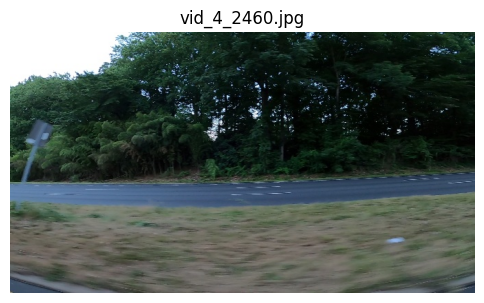

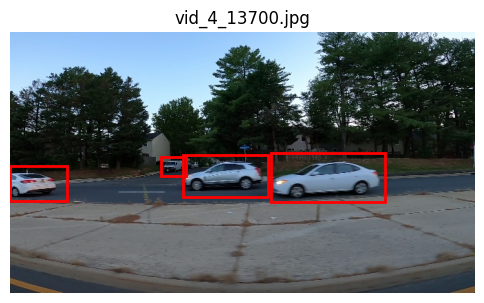

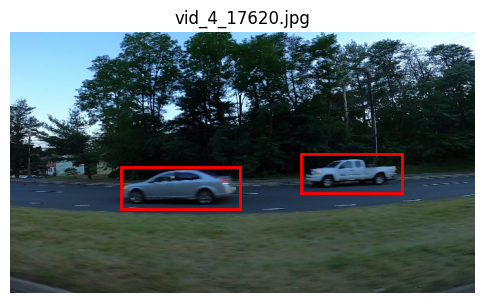

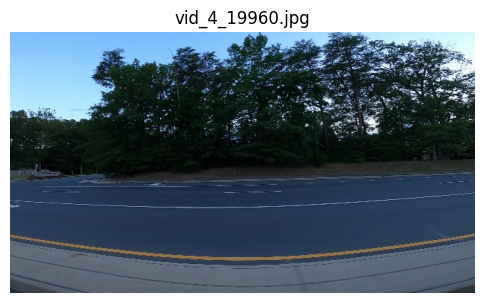

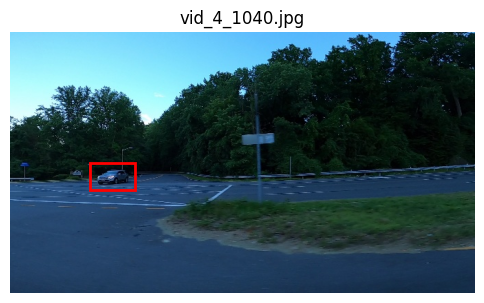

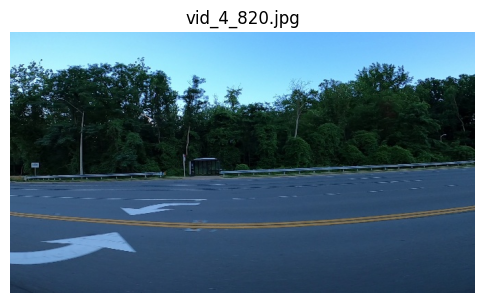

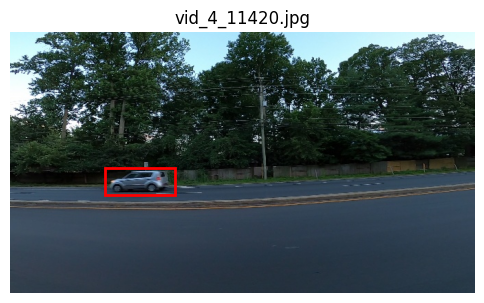

In [52]:
import os
import cv2
import matplotlib.pyplot as plt

IMG_SRC = "/kaggle/input/car-object-detection/data/training_images"

count = 0

for img_name in os.listdir(IMG_SRC):

    img_path = os.path.join(IMG_SRC, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get all boxes for this image
    boxes = labels[labels["image"] == img_name]

    plt.figure(figsize=(6,4))
    plt.imshow(img)

    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]

        # draw rectangle
        plt.gca().add_patch(
            plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                fill=False,
                edgecolor="red",
                linewidth=2
            )
        )

    plt.title(img_name)
    plt.axis("off")
    plt.show()

    count += 1
    if count == 10:
        break


In [53]:
from sklearn.model_selection import train_test_split

images = labels["image"].unique()

train_imgs, val_imgs = train_test_split(
    images,
    test_size=0.2,
    random_state=42
)

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))


Train images: 284
Val images: 71


In [54]:
import os 
BASE_DIR = "/kaggle/working/yolo_data" 
IMG_DIR = f"{BASE_DIR}/images" 
LBL_DIR = f"{BASE_DIR}/labels" 
for split in ["train", "val"]: 
    os.makedirs(f"{IMG_DIR}/{split}", exist_ok=True) 
    os.makedirs(f"{LBL_DIR}/{split}", exist_ok=True) 
print("YOLO folders created!")

YOLO folders created!


In [55]:
import cv2
import shutil
from tqdm import tqdm

IMG_SRC = "/kaggle/input/car-object-detection/data/training_images"

def convert_to_yolo(row, img_w, img_h):
    x_center = ((row.xmin + row.xmax) / 2) / img_w
    y_center = ((row.ymin + row.ymax) / 2) / img_h
    w = (row.xmax - row.xmin) / img_w
    h = (row.ymax - row.ymin) / img_h
    return f"0 {x_center} {y_center} {w} {h}"

def process_split(img_list, split):
    for img_name in tqdm(img_list):
        img_path = f"{IMG_SRC}/{img_name}"
        img = cv2.imread(img_path)
        h, w, _ = img.shape

        subset = labels[labels.image == img_name]

        label_file = f"{LBL_DIR}/{split}/{img_name.replace('.jpg','.txt')}"
        with open(label_file, "w") as f:
            for _, row in subset.iterrows():
                f.write(convert_to_yolo(row, w, h) + "\n")

        shutil.copy(img_path, f"{IMG_DIR}/{split}/{img_name}")

process_split(train_imgs, "train")
process_split(val_imgs, "val")

print("Images and labels moved to YOLO folders!")


100%|██████████| 71/71 [00:00<00:00, 184.11it/s]

Images and labels moved to YOLO folders!


In [56]:
print("Train images:", len(os.listdir(f"{IMG_DIR}/train")))
print("Train labels:", len(os.listdir(f"{LBL_DIR}/train")))
print("Val images:", len(os.listdir(f"{IMG_DIR}/val")))
print("Val labels:", len(os.listdir(f"{LBL_DIR}/val")))


Train images: 284
Train labels: 284
Val images: 71
Val labels: 71


In [57]:
BASE_DIR = "/kaggle/working/yolo_data"

data_yaml = f"""
path: {BASE_DIR}
train: images/train
val: images/val

nc: 1
names: ['car']
"""

with open("cars.yaml", "w") as f:
    f.write(data_yaml)

print("cars.yaml created")


cars.yaml created


In [68]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")   # pretrained lightweight model

model.train(
    data="cars.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device=0,
    #freeze=10, # maintains pretrained visual representations while fine-tuning detection head for task-specific learning
     # Light augmentations
    flipud=0.0,     # no vertical flip (cars upside down unrealistic)
    fliplr=0.5,     # horizontal flip 50%
    scale=0.5,      # random scale
    translate=0.1, # slight shift
    hsv_h=0.015,   # brightness/color jitter
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=5      # small rotation only
)


Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e8a6987d8e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [69]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")


In [70]:
#Run predictions on validation set
results = model.predict(
    source=f"{IMG_DIR}/val",
    conf=0.45,
    save=False
)


image 1/71 /kaggle/working/yolo_data/images/val/vid_4_10020.jpg: 384x640 1 car, 6.7ms
image 2/71 /kaggle/working/yolo_data/images/val/vid_4_10100.jpg: 384x640 1 car, 5.5ms
image 3/71 /kaggle/working/yolo_data/images/val/vid_4_1040.jpg: 384x640 1 car, 5.7ms
image 4/71 /kaggle/working/yolo_data/images/val/vid_4_10980.jpg: 384x640 1 car, 5.7ms
image 5/71 /kaggle/working/yolo_data/images/val/vid_4_11400.jpg: 384x640 1 car, 5.8ms
image 6/71 /kaggle/working/yolo_data/images/val/vid_4_11900.jpg: 384x640 1 car, 5.8ms
image 7/71 /kaggle/working/yolo_data/images/val/vid_4_11980.jpg: 384x640 1 car, 6.0ms
image 8/71 /kaggle/working/yolo_data/images/val/vid_4_12100.jpg: 384x640 2 cars, 6.1ms
image 9/71 /kaggle/working/yolo_data/images/val/vid_4_12180.jpg: 384x640 3 cars, 5.9ms
image 10/71 /kaggle/working/yolo_data/images/val/vid_4_12240.jpg: 384x640 4 cars, 6.1ms
image 11/71 /kaggle/working/yolo_data/images/val/vid_4_12300.jpg: 384x640 4 cars, 5.9ms
image 12/71 /kaggle/working/yolo_data/images/val

In [71]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2-x1) * max(0, y2-y1)

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = area1 + area2 - inter

    return inter / union if union > 0 else 0


In [72]:
import cv2

missed = 0
poor_localization = 0
false_positive = 0
correct = 0

IOU_THRESH = 0.5

for r in results:

    img_name = os.path.basename(r.path)
    gt_boxes = labels[labels.image == img_name][["xmin","ymin","xmax","ymax"]].values

    preds = r.boxes.xyxy.cpu().numpy() if r.boxes is not None else []

    matched_gt = set()

    for p in preds:
        best_iou = 0
        best_gt = None

        for i, gt in enumerate(gt_boxes):
            iou_val = iou(p, gt)
            if iou_val > best_iou:
                best_iou = iou_val
                best_gt = i

        if best_iou >= IOU_THRESH:
            correct += 1
            matched_gt.add(best_gt)
        else:
            poor_localization += 1

    missed += len(gt_boxes) - len(matched_gt)

    if len(preds) > len(gt_boxes):
        false_positive += len(preds) - len(gt_boxes)


In [73]:
print("Correct detections:", correct)
print("Missed cars:", missed)
print("Poor localization:", poor_localization)
print("False positives:", false_positive)


Correct detections: 115
Missed cars: 6
Poor localization: 6
False positives: 6


In [74]:
import pandas as pd

df = pd.DataFrame({
    "Error Type": ["Correct", "Missed", "Poor Localization", "False Positive"],
    "Count": [correct, missed, poor_localization, false_positive]
})

df


Error Type  Count
0            Correct    115
1             Missed      6
2  Poor Localization      6
3     False Positive      6

In [75]:
model.predict(
    source="/kaggle/input/car-object-detection/data/testing_images",
    save=True,
    conf=0.45
)



image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 6.1ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 5.7ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 5.7ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 6.0ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 5.9ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 5.8ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 5.9ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 5.6ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25260.

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car'}
 obb: None
 orig_img: array([[[254, 222, 187],
         [254, 222, 187],
         [251, 221, 186],
         ...,
         [239, 188, 138],
         [238, 187, 137],
         [238, 187, 137]],
 
        [[255, 223, 188],
         [255, 223, 188],
         [253, 223, 188],
         ...,
         [239, 188, 138],
         [239, 188, 138],
         [239, 188, 138]],
 
        [[254, 224, 189],
         [254, 224, 189],
         [254, 224, 189],
         ...,
         [239, 188, 138],
         [239, 188, 138],
         [240, 189, 139]],
 
        ...,
 
        [[ 57,  46,  38],
         [ 59,  48,  40],
         [ 60,  47,  39],
         ...,
         [ 38,  76, 100],
         [ 38,  75, 101],
         [ 38,  76, 100]],
 
        [[ 58,  44,  38],
         [ 59,  45,  39],
         [ 59,  45,  39],
         ...,
         [ 40,  77,  

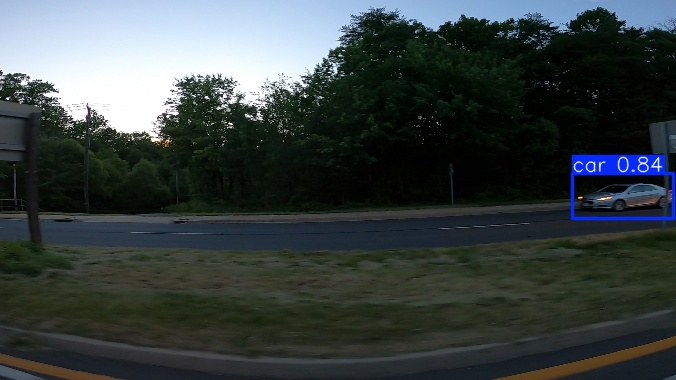

In [76]:
import os
from PIL import Image

pred_dir = "runs/detect/predict"
img = os.listdir(pred_dir)[35]

Image.open(f"{pred_dir}/{img}")


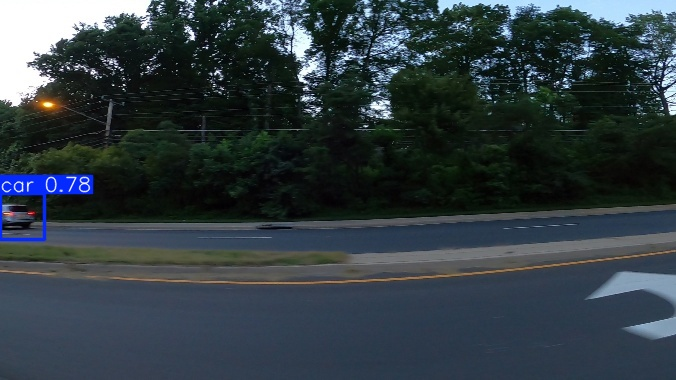

In [77]:
import os
from PIL import Image

pred_dir = "runs/detect/predict"
img = os.listdir(pred_dir)[17]

Image.open(f"{pred_dir}/{img}")
